In [67]:
from __future__ import division, print_function

import GPy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from utilities import *

We start by defining a discretization of the space $[-1, 1]$ with discretization constant $\tau$

In [68]:
# Discretization constant
tau = 0.001

# x_min, x_max, discretization
grid_param = [-1., 1., tau]

extent = np.array(grid_param[:2])

# Create a grid
grid = np.arange(*grid_param)[:, None]
num_samples = len(grid)

print('Grid size: {0}'.format(len(grid)))

Grid size: 2000


### Draw system dynamics from a GP

We define a kernel, $k(x,x') = k_{\mathrm{linear}}(x, x') * k_{\mathrm{Matern}}(x, x')$, which models a nonlinear, 2-times differentiable function with linearly increasing amplitude. We draw a sample from this kernel in order to define the dynamics.

The following plot shows the kind of functions that this kernel implies

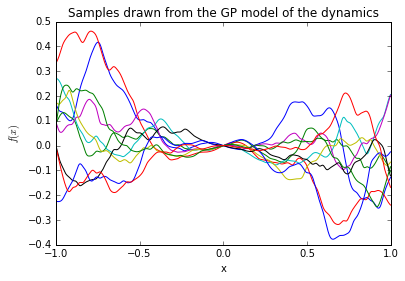

In [69]:
kernel = GPy.kern.Matern32(1, lengthscale=0.2, variance=0.2**2) * GPy.kern.Linear(1)

for i in range(10):
    f = sample_gp_function(kernel,
                           [extent],
                           num_samples=100,
                           noise_var=0.1,
                           interpolation='kernel')
    plt.plot(grid, f(grid, noise=False))

plt.ylabel('$f(x)$')
plt.xlabel('x')
plt.title('Samples drawn from the GP model of the dynamics')
plt.show()

We define the GP model using one particular sample of the GP, in addition to a stable, closed-loop, linear model.

\begin{equation}
\dot{x} = -0.25 x,
\end{equation}
which is asymptotically stable. 

Sample of a GP model are Lipschitz continuous with high probability.

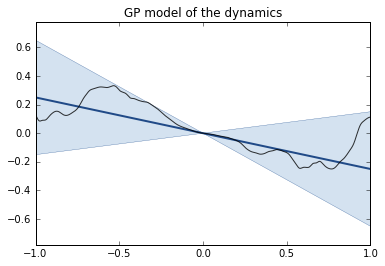

In [70]:
# Observation noise
noise_var = 0.01 ** 2

# Mean dynamics
mf = GPy.core.Mapping(1, 1)
mf.f = lambda x: -0.25 * x
mf.update_gradients = lambda a, b: None

# Define one sample as the true dynamics
np.random.seed(5)
true_dynamics = sample_gp_function(kernel,
                                   [extent],
                                   num_samples=100,
                                   noise_var=noise_var,
                                   interpolation='kernel',
                                   mean_function=mf.f)

gp = GPy.core.GP(np.array([[0]]), np.array([[0]]),
                 kernel, GPy.likelihoods.Gaussian(variance=noise_var),
                 mean_function=mf)

gp.plot_f(plot_limits=extent)
plt.plot(grid, true_dynamics(grid, noise=False), color='black', alpha=0.8)
plt.title('GP model of the dynamics')
plt.show()


Additionally we define a random lyapunov function. For 1D this doesn't really matter. Here we pick
\begin{equation}
V(x) = |x|
\end{equation}
The previous GP model defines a model over $\dot{V}(x) = \frac{\partial V(x)}{\partial x} f(x)$. In the following, we only consider the 2-$\sigma$ upper confidence bound of this model. Since the dynamics are Lipschitz continuous, $\dot{V}$ is Lipschitz continuous as well.

In particular, we use Lemma 5 to determine an appropriate Lipschitz constant.

In [71]:
def lyapunov(x):
    """
    Return the Lyapunov function and its derivative.
    
    Parameters
    ----------
    x: np.array
        The input data
    
    Returns
    V: np.array
        The function values, V(x)
    dV: np.array
        The derivatives, dV(x) / dx
    """
    return np.abs(x).squeeze(), np.sign(grid, dtype=np.float)

V, dV = quadratic_lyapunov_function(grid, np.array([[1]]))

# V, dV = lyapunov(grid)
accuracy = np.max(V) / 1e10
beta = 2

# Lipschitz constant
L_dyn = 0.25 + beta * np.sqrt(gp.kern.Mat32.variance) / gp.kern.Mat32.lengthscale * np.max(np.abs(extent))
B_dyn = (0.25 + np.sqrt(gp.kern.Mat32.variance)) * np.max(np.abs(extent))
B_dV = L_V = np.max(dV)
L_dV = 1

L = B_dyn * L_dV + B_dV * L_dyn

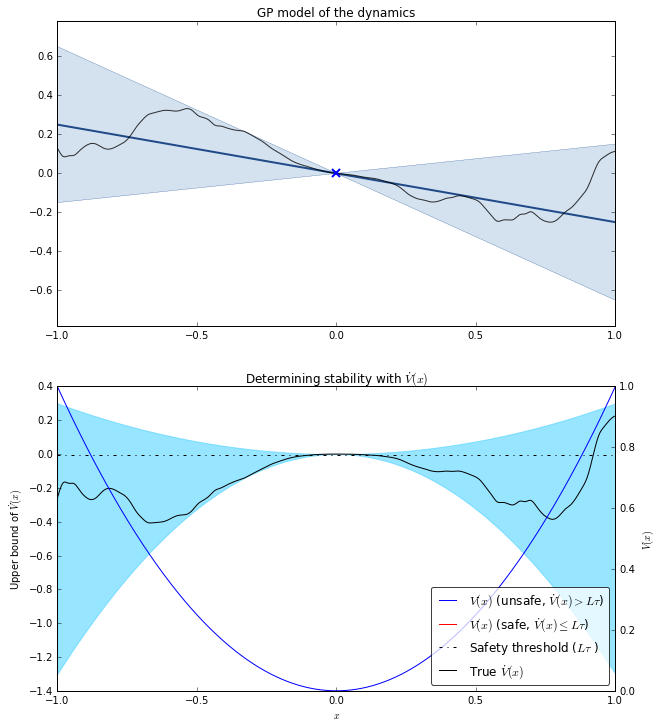

In [72]:
mean, var = gp._raw_predict(grid)
V_dot_mean, V_dot_var = compute_v_dot_distribution(dV, mean, var)
S = get_safe_set(V_dot_mean + beta * np.sqrt(V_dot_var),
                 -L*tau,
                 S0=None)

def plot_model(V_dot_mean, V_dot_var, S):    
    fig, axes = plt.subplots(2, 1, figsize=(10, 12))

    # Plot dynamics
    gp.plot_f(plot_limits=extent, ax=axes[0])
    axes[0].plot(grid, true_dynamics(grid, noise=False), color='black', alpha=0.8)
    axes[0].set_title('GP model of the dynamics')
    axes[0].plot(gp.X, gp.Y, 'x', ms=8, mew=2)

    # Plot V_dot
    v_dot_est_plot = plt.fill_between(grid.squeeze(),
                                      V_dot_mean + beta * np.sqrt(V_dot_var),
                                      V_dot_mean - beta * np.sqrt(V_dot_var),
                                      color='#33CCFF', alpha=0.5)
    threshold = plt.plot(extent, [-L*tau, -L*tau], 'k-.', label=r'Safety threshold ($L \tau$ )')
    v_dot_true_plot = axes[1].plot(grid, dV * true_dynamics(grid, noise=False), 'k',
                                   label=r'True $\dot{V}(x)$')
    axes[1].set_xlim(extent)
    axes[1].set_xlabel('$x$')
    axes[1].set_ylabel(r'Upper bound of $\dot{V}(x)$')
    axes[1].set_title(r'Determining stability with $\dot{V}(x)$')

    ax2 = axes[1].twinx()
    V_unsafe = np.ma.masked_where(S, V)
    V_safe = np.ma.masked_where(~S , V)
    unsafe_plot = ax2.plot(grid, V_unsafe, 'b', label=r'$V(x)$ (unsafe, $\dot{V}(x) > L \tau$)')
    safe_plot = ax2.plot(grid, V_safe, 'r', label=r'$V(x)$ (safe, $\dot{V}(x) \leq L \tau$)')
    ax2.set_ylabel(r'$V(x)$')
    ax2.set_xlim(extent)

    lns = unsafe_plot + safe_plot + threshold + v_dot_true_plot
    labels = [x.get_label() for x in lns]
    
    plt.legend(lns, labels, loc=4, fancybox=True, framealpha=0.75)
    plt.show()

plot_model(V_dot_mean, V_dot_var, S)

Clearly the model does not allow us to classify any states as safe ($\dot{V} < -L \tau$). However, as a starting point, we assume that we know that the system is asymptotially stable within some initial set, $\mathcal{S}_0$:
\begin{equation}
\mathcal{S}_0 = \{ x \in \mathbb{R} \,|\, |x| < 0.2 \}
\end{equation}

In [73]:
S0 = np.abs(grid.squeeze()) < 0.2

As we sample within this initial safe set, we gain more knowledge about the system. In particular, we continuously select the most uncertain state within the safe set

In [74]:
def update_gp():
    dynamics_mean, dynamics_var = gp._raw_predict(grid)
    V_dot = compute_v_dot_upper_bound(dV, dynamics_mean, dynamics_var, beta=2.)
    S = get_safe_set(V_dot, L*tau, S0=S0)
    c = find_max_levelset(S, V, accuracy)
    S[:] = V <= c
    max_id = np.argmax(dynamics_var[S])
    max_state = grid[S][[max_id], :].copy()
    gp.set_XY(np.vstack([gp.X, max_state]),
              np.vstack([gp.Y, true_dynamics(max_state, noise=True)[:, [0]]]))
    return S

In [75]:
for i in range(4):
    update_gp()

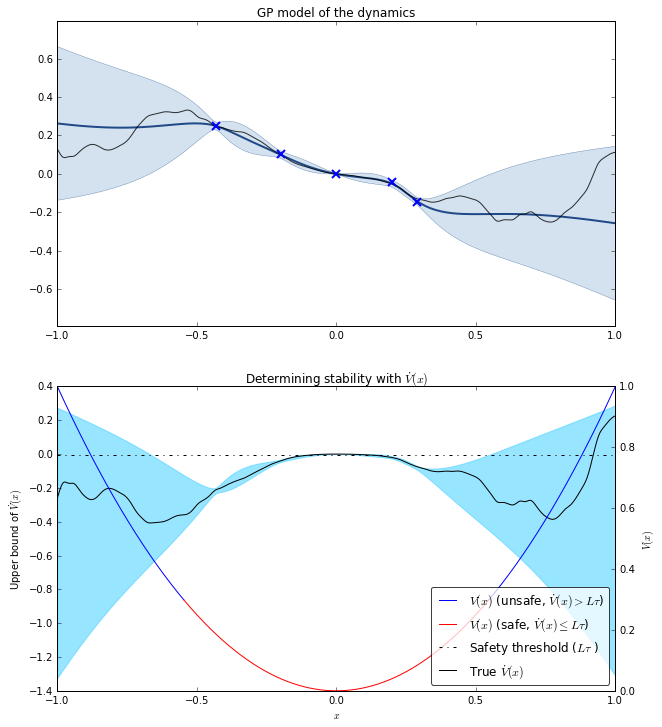

In [76]:
mean, var = gp._raw_predict(grid)
V_dot_mean, V_dot_var = compute_v_dot_distribution(dV, mean, var)
S = get_safe_set(V_dot_mean + beta * np.sqrt(V_dot_var),
                 -L*tau,
                 S0=S0)
c = find_max_levelset(S, V, accuracy)
S[:] = V < c
    
plot_model(V_dot_mean, V_dot_var, S)

We continue to sample like this, until we find the maximum safe set

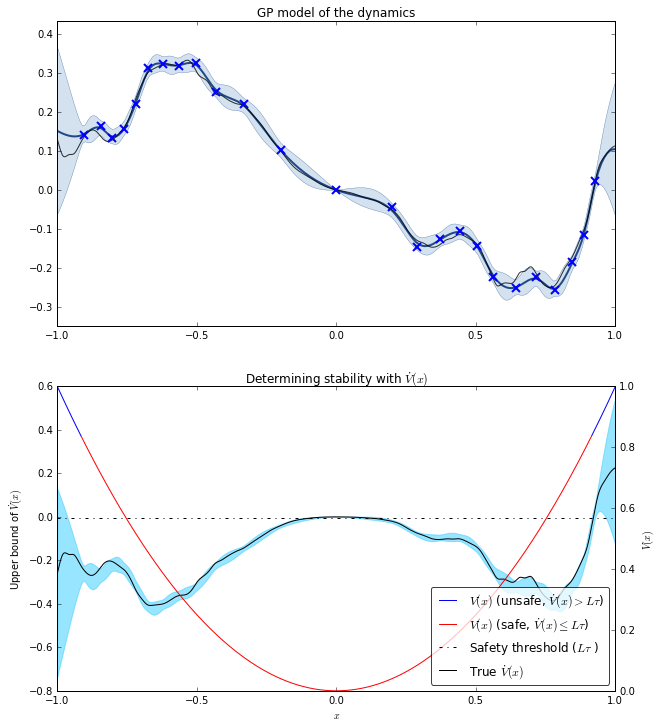

In [77]:
for i in range(20):
    update_gp()
    
mean, var = gp._raw_predict(grid)
V_dot_mean, V_dot_var = compute_v_dot_distribution(dV, mean, var)
S = get_safe_set(V_dot_mean + beta * np.sqrt(V_dot_var),
                 -L*tau,
                 S0=S0)
c = find_max_levelset(S, V, accuracy)
S[:] = V < c
    
plot_model(V_dot_mean, V_dot_var, S)